In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter


In [2]:
# Load datasets
visits = pd.read_csv('./dataset/calendar.csv')
reviews = pd.read_csv('./dataset/reviews.csv')
listings = pd.read_csv('./dataset/listings.csv')

# Clean and preprocess data
visits['price'] = visits['price'].str.strip('$').str.replace(',','').astype(float)   # convert $ values to float
listings.rename(columns={'id': 'listing_id'}, inplace=True)

Analyze the most prevalent words in listings' descriptions

In [3]:
# Count words
word_count = Counter()
listings['description'].str.lower().str.split().apply(word_count.update)

# Remove non-informative words
fluff_words = ['the', 'and', 'at', 'an', 'it\'s', 'or', 'great', 'your', 'all.', 'just', 'as', 'that', 'there', 'we', 
               'have',  'a', 'also', 'to', 'in', 'my', 'is', 'it', 'if', 'of', 'with', 'our', 'has', 'for', 'you', 'be', 
               'on', 'this', 'from', 'boston', 'are', 'walk']
for fluff in fluff_words:
    if fluff in word_count:
        del word_count[fluff]
        

(-0.5, 999.5, 499.5, -0.5)

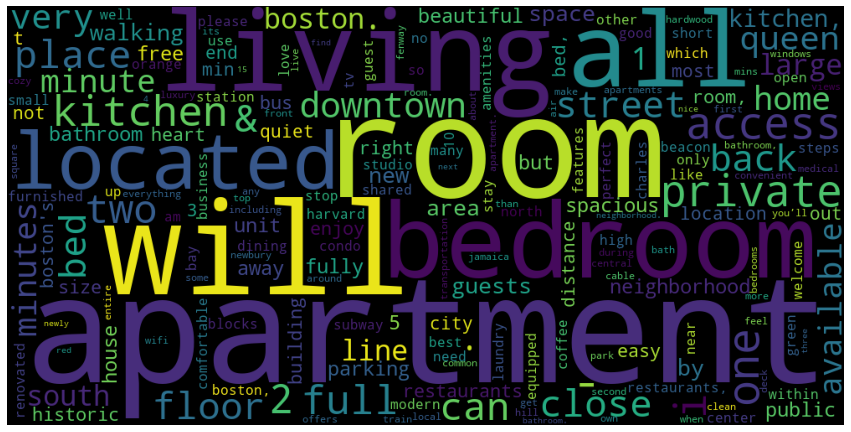

In [4]:
# Generate word cloud for most common words
word_count = dict(word_count)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_count)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

Analyze satisfaction across price cohorts

In [7]:
# Add average prices per listing
avg_prices = visits.dropna(subset=['price'], how='any', axis=0).groupby(by='listing_id').agg(avg_price=('price','mean'))
listings_w_prices = listings.join(avg_prices, on='listing_id', how='left')
listings_w_prices = listings_w_prices.dropna(axis=1, how='all')

# Label listings with average price quartile
listings_w_prices = listings_w_prices.dropna(subset=['avg_price'], how='any', axis=0)
listings_w_prices['price_quartile'] = pd.qcut(listings_w_prices['avg_price'], q=4, labels=['low', 'low_med', 'high_med', 'high'])

<AxesSubplot:title={'center':'review_scores_rating'}, xlabel='price_quartile'>

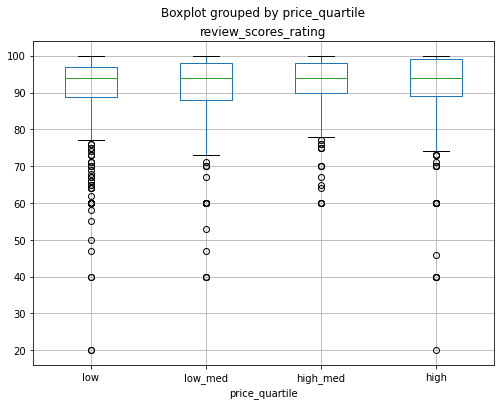

In [12]:
# Plot satisfaction across price quartiles
fig, ax = plt.subplots(figsize=(8,6))
listings_w_prices.boxplot(column=['review_scores_rating'], by='price_quartile', ax=ax)

<AxesSubplot:>

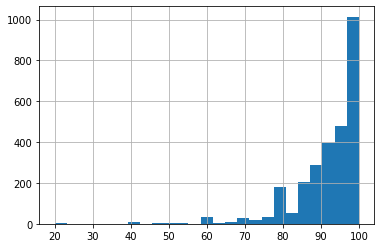

In [14]:
# Data is super skewed and there is no real difference between satisfaction in higher or lower priced listings
listings['review_scores_rating'].hist(bins=25)

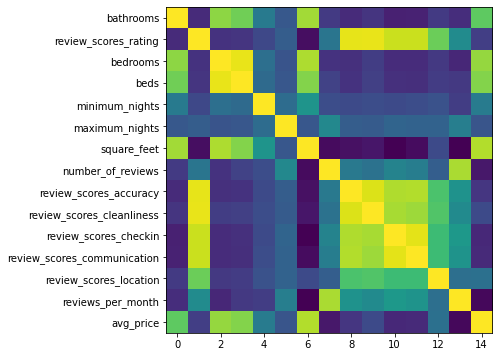

In [29]:
# Analyze correlation between features and price
num_features = ['bathrooms', 'review_scores_rating', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights','square_feet', 'number_of_reviews', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month', 'avg_price']
listings_num_df = listings_w_prices[num_features]
listings_w_prices_corr = listings_num_df.corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(8,6))
plt.yticks([x for x in range(len(listings_w_prices_corr.columns))], [x for x in listings_w_prices_corr.columns])
plt.imshow(listings_w_prices_corr.select_dtypes(['float', 'int']).corr())

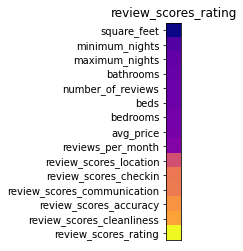

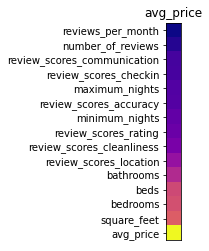

In [30]:
# get relevant numerical features
num_features = ['bathrooms', 'review_scores_rating', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights','square_feet', 'number_of_reviews', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month', 'avg_price']

# check the correlaction with price and score ratings
listings_num_df = listings_w_prices[num_features]
listings_w_prices_corr = listings_num_df.corr()

for stat in ['review_scores_rating', 'avg_price']:
    listings_w_prices_corr = listings_w_prices_corr.sort_values(by=stat)
    plt.yticks([x for x in range(len(listings_w_prices_corr.index))], [x for x in listings_w_prices_corr.index])
    plt.xticks([])
    plt.title(stat)
    plt.imshow(listings_w_prices_corr[[stat]], cmap='plasma')
    plt.show()

In [31]:
# Analyze categorical features
cat_features = ['cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'host_is_superhost', 'host_response_time', 'neighbourhood_cleansed', 'host_identity_verified', 'property_type', 'room_type', 'bed_type', 'amenities']
listings_cat_df = listings_w_prices[cat_features]

# Preprocess amenities feature
listings_cat_df['amenities'] = listings_cat_df['amenities'].str.replace('{', '', regex=True).str.replace('}', '', regex=True).str.replace('"', '', regex=True).str.lower()
listings_cat_df['amenities'].fillna('x', inplace=True)
amenities_types = Counter()
listings_cat_df['amenities'].str.lower().str.split(',').apply(amenities_types.update)
amenities_types = [x for x in dict(amenities_types.most_common(20)).keys()]

# Create dummy variables for amenities
for amenity in amenities_types:
    listings_cat_df[amenity] = listings_cat_df['amenities'].apply(lambda x: 1 if x.find(amenity) != -1 else 0)
    
# Drop amenities lists
listings_cat_df.drop(columns=['amenities'], inplace=True)

C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_22380\1749133396.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_cat_df['amenities'] = listings_cat_df['amenities'].str.replace('{', '', regex=True).str.replace('}', '', regex=True).str.replace('"', '', regex=True).str.lower()
C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_22380\1749133396.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_cat_df['amenities'].fillna('x', inplace=True)
C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_22380\1749133396.py:14: SettingWithCopyWarning: 
A value i

In [32]:
# Replace nulls with columns' mean for numerical variables
listings_num_df[num_features[:-1]] = listings_num_df[num_features[:-1]].fillna(listings_num_df[num_features[:-1]].mean())

# Concatenate numerical and categorical dataframes
ln_df = pd.concat([listings_num_df, listings_cat_df], axis=1)

# Dummy the categorical variables
for col in ln_df.select_dtypes('object').columns:
    ln_df = pd.concat([ln_df.drop(columns=[col]), pd.get_dummies(ln_df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_22380\852601208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_num_df[num_features[:-1]] = listings_num_df[num_features[:-1]].fillna(listings_num_df[num_features[:-1]].mean())


In [34]:
# Split into features and targets
X = ln_df.drop(columns=['avg_price'], axis=1)
y = ln_df['avg_price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

# Train linear regression model
linear_model = LinearRegression()                     # Instantiate
linear_model.fit(X_train, y_train)                    # Fit

# Predict and assess the r2 score
y_test_preds = linear_model.predict(X_test)
r2 = r2_score(y_test, y_test_preds)
print(f"R2 score: {r2}")

# Display feature importance
coefficients_df = pd.DataFrame({'features': X_train.columns, 'coefficients': linear_model.coef_}).sort_values('coefficients', ascending=False)

R2 score: 0.3272820341131142


In [35]:
print(coefficients_df.head(15))

                                          features  coefficients
60         neighbourhood_cleansed_Leather District    192.323202
68  neighbourhood_cleansed_South Boston Waterfront    130.632883
53                neighbourhood_cleansed_Chinatown    107.699226
49              neighbourhood_cleansed_Bay Village    104.370762
48                 neighbourhood_cleansed_Back Bay    101.306373
55                 neighbourhood_cleansed_Downtown     85.443390
70                 neighbourhood_cleansed_West End     85.143837
50              neighbourhood_cleansed_Beacon Hill     84.466213
57                   neighbourhood_cleansed_Fenway     73.093841
69                neighbourhood_cleansed_South End     69.980383
2                                         bedrooms     55.370404
64                neighbourhood_cleansed_North End     49.425795
61    neighbourhood_cleansed_Longwood Medical Area     38.948432
0                                        bathrooms     34.929827
63             neighbourh

In [36]:
print(coefficients_df.tail(15))

                               features  coefficients
94                    bed_type_Real Bed    -29.855175
19                       smoke detector    -32.328012
46    host_response_time_within an hour    -32.641352
62      neighbourhood_cleansed_Mattapan    -34.010400
86                  property_type_Villa    -35.110227
65    neighbourhood_cleansed_Roslindale    -35.118194
58     neighbourhood_cleansed_Hyde Park    -37.570647
71  neighbourhood_cleansed_West Roxbury    -38.955778
93               bed_type_Pull-out Sofa    -40.737891
15                              heating    -46.523480
44      host_response_time_within a day    -54.360241
91                       bed_type_Couch    -62.153187
88               room_type_Private room    -69.715899
89                room_type_Shared room    -88.243667
77              property_type_Camper/RV   -198.982111
